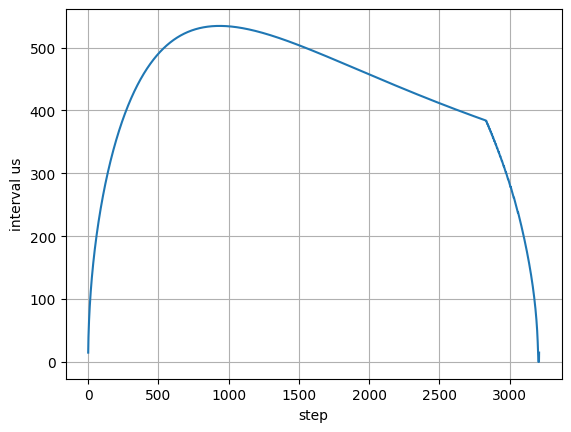

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import math

class AccelStepper:
    pos: int = 0
    target: int = 0
    speed: float = 0.0
    max_speed: float = 1.0
    step_div: int = 16
    steps_per_rev: int = 200
    step_interval_us: int = 0.0
    dir_cw: bool = False
    local_step: int = 0
    accel: float = 1.0

    def __init__(self, accel: float, max_speed: float):
        self.accel = accel
        self.max_speed = max_speed

    def min_interval(self) -> int:
        return int(0.676 * math.sqrt(2.0 / self.accel) * 1_000_000.0)

    def max_interval(self) -> int:
        return 1_000_000 / (self.max_speed * self.steps_per_rev / 60.0)

    def move_to(self, target):
        self.target = target

    def step(self) -> int:
        dist = self.target - self.pos
        steps_to_stop = self.speed ** 2 / (2.0 * self.accel)

        if dist == 0 and steps_to_stop <= 1:
            self.step_interval_us = 0
            self.speed = 0.0
            self.local_step = 0
            return 1_000_000

        if dist > 0:
            if self.local_step > 0:
                if steps_to_stop >= dist or not self.dir_cw:
                    self.local_step = -steps_to_stop
            elif self.local_step < 0:
                if steps_to_stop < dist and self.dir_cw:
                    self.local_step = -self.local_step
        elif dist < 0:
            if self.local_step > 0:
                if steps_to_stop >= -dist or self.dir_cw:
                    self.local_step = -steps_to_stop
            elif self.local_step < 0:
                if steps_to_stop < -dist and not self.dir_cw:
                    self.local_step = -self.local_step

        if self.local_step == 0:
            self.dir_cw = dist > 0
            self.step_interval_us = self.min_interval()
        else:
            self.step_interval_us = max(self.step_interval_us - (2.0 * self.step_interval_us) / (4.0 * self.local_step) + 1.0, self.max_interval())

        self.local_step += 1
        self.speed = 1_000_000.0 / self.step_interval_us * 1.0 if self.dir_cw else -1.0
        self.pos += 1 if self.dir_cw else -1

        return self.step_interval_us

stepper = AccelStepper(200.0, 500.0)

stepper.move_to(3200)
speed = [1_000_000 / stepper.step() for i in range(3210)]
plt.plot(speed)
# stepper.move_to(0)
# speed = [1_000_000 / stepper.step() for i in range(3210)]
# plt.plot(speed)

plt.grid()
plt.xlabel('step')
plt.ylabel('interval us')
plt.show()

